# Workflow Debugging

(806, 20)
Metal device set to: Apple M1 Pro
Epoch 1/100


2022-04-21 11:44:13.238812: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-21 11:44:13.238937: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-21 11:44:13.326462: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 8/18 [============>.................] - ETA: 0s - loss: 14.7893 - accuracy: 0.3008    

2022-04-21 11:44:13.490545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 8ms/step - loss: 7.8879 - accuracy: 0.4326
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 2.9019 - accuracy: 0.6241
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 1.5999 - accuracy: 0.6809
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.9168 - accuracy: 0.7021
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.7089 - accuracy: 0.7163
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.6611 - accuracy: 0.7872
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.6153 - accuracy: 0.7713
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.6386 - accuracy: 0.7713
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.6351 - accuracy: 0.7961
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.5665 - accuracy: 0.8014
Epoch 11/100
18/18 [=

18/18 [==============================] - 0s 6ms/step - loss: 0.2436 - accuracy: 0.9238
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2360 - accuracy: 0.9096
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2253 - accuracy: 0.9167
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2184 - accuracy: 0.9220
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2791 - accuracy: 0.8989
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2748 - accuracy: 0.8972
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2269 - accuracy: 0.9043
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2863 - accuracy: 0.9078
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2248 - accuracy: 0.9113
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2366 - accuracy: 0.9025
Epoch 93/100


2022-04-21 11:44:25.366290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy on test data: 0.8429752588272095% 
 Error on test data: 0.15702474117279053
len(y_predicted) 242
wstate_121  predicted:  5  should be:  0  diff:  283.18268677261767
portfoliovqe_16  predicted:  1  should be:  0  diff:  2336.649282111426
graphstate_35  predicted:  0  should be:  5  diff:  1380.038304685525


2022-04-21 11:44:25.606479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


graphstate_32  predicted:  5  should be:  0  diff:  1717.9504900574848
graphstate_24  predicted:  1  should be:  5  diff:  532.2869302878016
dj_44  predicted:  0  should be:  5  diff:  1948.1418425480097
ghz_130  predicted:  5  should be:  0  diff:  0
qpeexact_13  predicted:  2  should be:  1  diff:  987746.0011941936
wstate_129  predicted:  5  should be:  0  diff:  0
graphstate_22  predicted:  1  should be:  0  diff:  658.0813899210534
portfoliovqe_15  predicted:  1  should be:  0  diff:  2083.4504204772547
wstate_123  predicted:  5  should be:  0  diff:  635.6271177689223
ae_16  predicted:  1  should be:  0  diff:  477.9587328428879
wstate_11  predicted:  5  should be:  2  diff:  724.576597932265
dj_34  predicted:  0  should be:  5  diff:  2269.5886336651524
dj_9  predicted:  5  should be:  2  diff:  1533.6485362201925
portfoliovqe_8  predicted:  1  should be:  2  diff:  11271.180407623706
portfoliovqe_14  predicted:  1  should be:  0  diff:  3740.309334837075
dj_42  predicted:  0  s

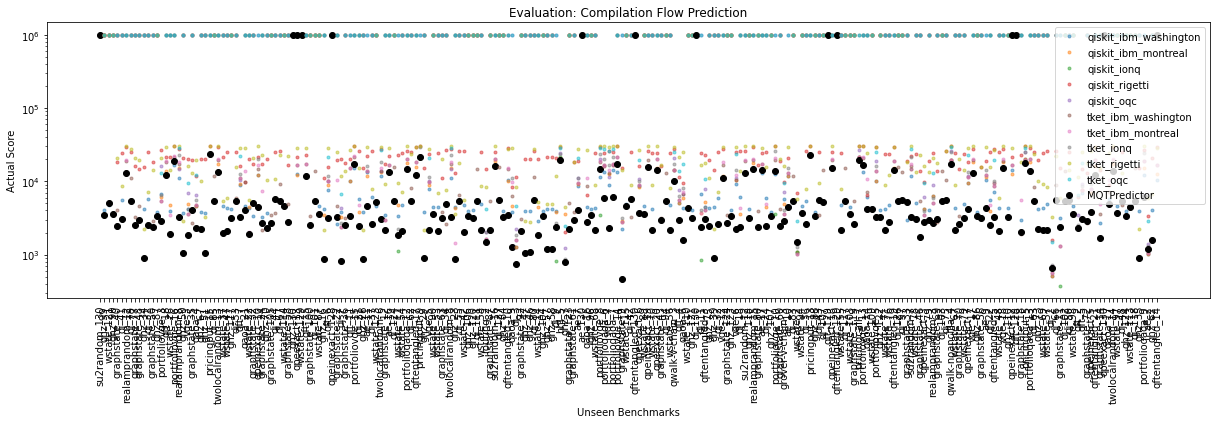

In [1]:
from evaluator.eval import extract_training_data_from_json, train_simple_ml_model
import numpy as np
training_data, names_list, scores_list = extract_training_data_from_json("json_data_big_server.json")
#print(names_list)
X, y = zip(*training_data)
X = np.array(X)
y = np.array(y)
non_zero_indices = []
for i in range(len(X[0])):
    if sum(X[:,i]) > 0:
        non_zero_indices.append(i)
X = X[:, non_zero_indices]
print(X.shape)
train_simple_ml_model(X,y, True, names_list, scores_list)

In [2]:
from sklearn.model_selection import train_test_split
from evaluator.src import utils
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

openqasm_gates_list = utils.get_openqasm_gates()
res = [openqasm_gates_list[i] for i in range(0, len(openqasm_gates_list))]
res.append("num_qubits")


features = np.sort(np.array(res))
features = features[non_zero_indices]
print(features)


['ccx' 'cp' 'cry' 'cu' 'cu1' 'cx' 'cz' 'h' 'num_qubits' 'p' 'rx' 'ry' 'rz'
 'rzz' 'swap' 'u' 'u1' 'u2' 'u3' 'x']


0.8759398496240601
Predicted machines:  {0, 1, 2, 5}
Actual machines:  {0, 1, 2, 5}
predicted  5  should be  0
predicted  0  should be  2
predicted  0  should be  5
predicted  0  should be  5
predicted  5  should be  0
predicted  0  should be  5
predicted  5  should be  0
predicted  1  should be  5
predicted  1  should be  0
predicted  0  should be  5
predicted  0  should be  2
predicted  2  should be  5
predicted  5  should be  0
predicted  1  should be  0
predicted  0  should be  2
predicted  0  should be  5
predicted  0  should be  5
predicted  0  should be  5
predicted  0  should be  5
predicted  0  should be  5
predicted  0  should be  5
predicted  5  should be  0
predicted  0  should be  5
predicted  0  should be  5
predicted  1  should be  5
predicted  1  should be  0
predicted  0  should be  5
predicted  1  should be  0
predicted  0  should be  5
predicted  1  should be  2
predicted  1  should be  5
predicted  0  should be  1
predicted  0  should be  1


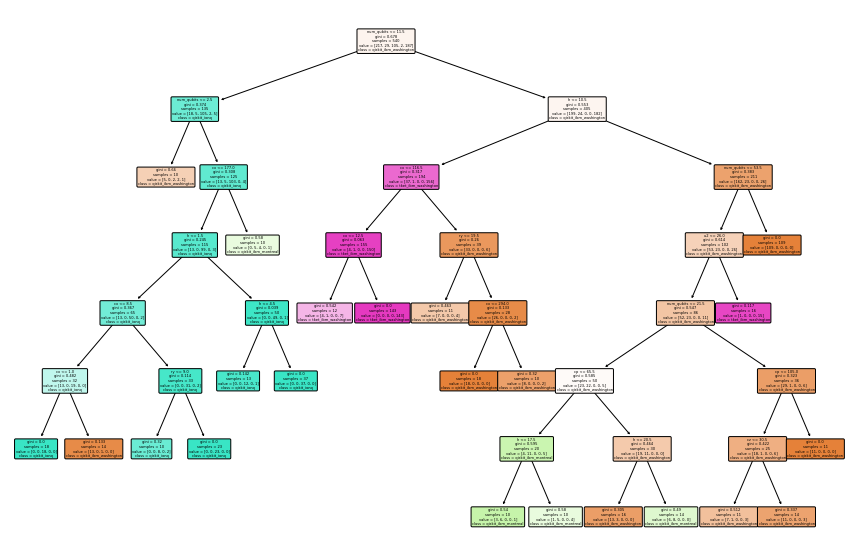

In [11]:

import matplotlib.pyplot as plt
from evaluator.src import utils
from sklearn.tree import plot_tree
from sklearn import tree


clf = tree.DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
clf = clf.fit(X_train, y_train)
clf.predict(X_test)

fig = plt.figure(figsize=(15, 10))

y_pred=clf.predict(X_test)
print(np.mean(y_pred == y_test))
available_machines = [utils.get_machines()[i] for i in set(clf.classes_)]
plot_tree(clf, 
          feature_names=features,
          class_names=available_machines,
          filled=True, impurity=True, 
          rounded=True);
plt.savefig("DecisionTreeClassifier.png", dpi=600)

print("Predicted machines: ", set(y_pred))
print("Actual machines: ", set(y_test))
for i in range(len(y_pred)):
    if y_pred[i] != y_test[i]:
        print("predicted ", y_pred[i], " should be ", y_test[i])

In [4]:
clf.classes_

array([0, 1, 2, 4, 5])

In [5]:
print(clf.predict([X[2]]))

[5]


# Other tested Models

In [6]:
from sklearn.naive_bayes import GaussianNB

clf=GaussianNB()

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print(np.mean(y_pred == y_test))

0.7105263157894737


In [7]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
#Create a Gaussian Classifier


clf = AdaBoostClassifier(n_estimators=10)
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print(np.mean(y_pred == y_test))

0.5676691729323309


1 0.8947368421052632
2 0.868421052631579
3 0.8984962406015038
4 0.9135338345864662
5 0.924812030075188
6 0.9210526315789473
7 0.9323308270676691
8 0.9210526315789473
9 0.9398496240601504


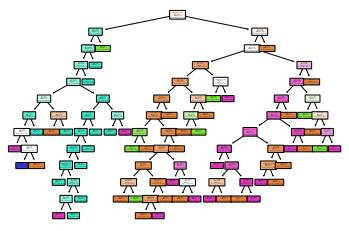

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

#Create a Gaussian Classifier
for i in range(1,10,1):
    clf=RandomForestClassifier(n_estimators=i)

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train,y_train)

    y_pred=clf.predict(X_test)
    print(i, np.mean(y_pred == y_test))
    plot_tree(clf.estimators_[0], 
          feature_names=features,
          class_names=utils.get_machines(),
          filled=True, impurity=True, 
          rounded=True);

In [9]:
from sklearn.svm import SVC
#Create a Gaussian Classifier

clf=SVC(kernel="linear")

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print(np.mean(y_pred == y_test))

0.8533834586466166


# Debugging

In [10]:
from evaluator import eval
from evaluator.src import utils, pytket_plugin, qiskit_plugin
import pytest
from pytket.extensions.qiskit import qiskit_to_tk
from mqt.bench import get_one_benchmark
from pytket import circuit, OpType